# <div align='center'> Exploração de um dataset utilizando técnicas de Visualização de Dados </div>
##<div align='center'>Trabalho final apresentado na disciplina Visualização de Dados do Curso de Pós Graduação em Inteligência Artificial e Aprendizado de Máquina - PUC Minas</div>

**Autor**: Lucas Lima dos Santos
**Professor**: Felipe Coelho Silva

# Introdução
Nos ultimos anos, a população dos Estados Unidos da America vem fazendo diversos protestos contra a atuação policial, se queixando sobre abuso de altoridade, racismo dentre outras coisas. Podemos citar como exemplo o caso do George Floyd, que causou comoção mundial, devido a uma morte causada por irresponsabilidade da policia americana.

Com base nesses acontecimentos, irei fundamentar o trabalho para poder investigar quais são as realações que uma morte causada pela policia americana pode ter.

Para isso utilizarei um dataset disponibilizado no github do "The Washington Post" (https://github.com/washingtonpost/data-police-shootings), que também está disponível no link https://www.kaggle.com/ahsen1330/us-police-shootings, já tratado e categorizado.

Esse dataset contém registros de todos os disparos fatais nos Estados Unidos por um policial em serviço desde 1º de janeiro de 2015. Dentre os dados temos: Nome da vitima, Data da Morte, Raça, Gênero Sexual, Idade, Local dentre outros.

# Preparação dos Dados -

Antes de iniciar as análises, irei importar o dataset direto da fonte de GitHub do The Whashington Post's, pois ele sempre atualiza essa base de dados com os dados mais recentes, por esse motivo não estarei utilizando o dataset tratado do Kaggle que está com os dados apenas até 2020, porem utilizarei algumas tratativas adotadas nesse dataset como a retirada dos valores nulos e a categorização das armas do assassinado, e também adicionarei outras tratativas que serão utilizadas durante a análise.

Irei utilizar o pandas para manipulação do DataSet e o Altair para visualização dos Gráficos

In [202]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [222]:
import pandas as pd
import numpy as np
import altair as alt
import plotly.express as px
from vega_datasets import data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud

In [204]:
df = pd.read_csv("https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv", index_col = 'id')

Primeiro vou checar a quantidade de dados faltantes dentro do dataset.

In [205]:
df.isnull().sum()

name                       240
date                         0
manner_of_death              0
armed                      208
age                        288
gender                       1
race                       603
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       399
body_camera                  0
longitude                  309
latitude                   309
is_geocoding_exact           0
dtype: int64

Apesar da raça ser importante para as nossas análises, o Altair não estava suportando mais de 5000 registro para plotar os gráficos, portanto irei desconsiderar os registros que não possuem raça preenchida ao inves de colocar eles na raça "Other" como feito abaixo.

In [206]:
df = df.loc[df.race.notnull()]

Para as demais colunas irei também deletar os valores vazios, pois não temos informações disponíveis nesse dataset para poder preenche-los.

In [207]:
df = df.dropna()

Depois de Remover os registros com informação faltando, irei categorizar algumas informações como a arma que está sendo utilizada pelo Assassinado, a Raça e o Ano da Morte.

In [208]:
unknowns_dict = ['unknown', 'undetermined', 'unidentifiable', 'claimed to be armed']
df.armed.loc[df.armed.str.contains('|'.join(unknowns_dict),case = False)] = 'unknown'

In [209]:
tipoArmas_dict = {
    'Guns': 
        ['bb gun', 'pellet gun', 'air pistol', 'bean-bag gun', 'gun', 'airsoft pistol'],
    'Blunt instruments':
        ['hammer', 'axe', 'ax', 'hatchet', 'crowbar', 'pole', 'rod', 'walking stick', 'stick', 'rock', 'baton', 'shovel',
        'metal object', 'baseball bat', 'bat', 'flagpole', 'metal pole', 'metal stick', 'blunt object', 'metal pipe', 
         'carjack', 'brick', 'garden tool', 'metal rake', 'mace', 'wrench', 'pipe'],
    'Sharp objects':
        ['knife', 'bayonet', 'razor', 'blade', 'machete', 'sword', 'chainsaw', 'chain saw' , 'sharp object', 'scissor',
         'scissors','chain saw', 'glass shard', 'samurai sword', 'lawn mower blade', 'box-cutter', 'straight edge razor',
        'beer bottle', 'bottle', 'sharp object','meat cleaver', 'box cutter'],
    'Piercing objects':
        ['spear', 'pick-axe', 'pick axe', 'pitchfork', 'cordless drill', 'nail gun', 'nailgun', 'pen',
        'crossbow', 'arrow and bow', 'screwdriver', 'ice pick', 'bow and arrow', 'railroad spikes'],
    'Other unusual objects':
        ['oar', 'chair', 'barstool', 'pepper spray', 'spray', 'wasp spray', 'piece of wood', 'binoculars', 'tire iron',
        'toy weapon', 'torch', 'flashlight', 'air conditioner', 'hand torch', "contractor's level", 'chain', 'stapler'],
    'Hand tools':
        ['metal hand tool'],
    'Vehicles':
        ['motorcycle', 'car', 'van', 'wagon', 'bike', 'vehicle'],
    'Electrical devices':
        ['taser'],
    'Explosives':
        ['fireworks', 'grenade', 'molotov cocktail', 'incendiary device']
}

In [210]:
def definirAno(row):
    data = row['date']
    row['year'] = data.split('-')[0]
    return row

anos = df
anos['year'] = '2021'
anos = anos.apply(definirAno, axis = 'columns')
df = anos

In [211]:
def definirMes(row):
    data = row['date']
    row['month'] = data.split('-')[1]
    return row

meses = df
meses['month'] = '01'
meses = meses.apply(definirMes, axis = 'columns')
df = meses

In [212]:
def definirTipoArma(row):
    armed = row['armed'].lower()
    if 'and' in armed.split(' '): 
        row['arms_category'] = 'Multiple'
    elif armed in tipoArmas_dict.keys():
        row['arms_category'] = armed
    elif armed == 'unknown' or armed == 'undetermined' or armed == 'unknown weapon':
        row['arms_category'] = 'Unknown'
    elif armed == 'unarmed':
        row['arms_category'] = 'Unarmed'
    else:
        for key, value in tipoArmas_dict.items():
            if armed in value:
                row['arms_category'] = key
    return row

tipoArmas = df
tipoArmas['arms_category'] = 'Unknown'
tipoArmas = tipoArmas.apply(definirTipoArma, axis = 'columns')
df = tipoArmas

In [213]:
def definirRaca(race):
    if race == 'A':
        race = 'Asian'
    elif race == 'B':
        race = 'Black'
    elif race == 'H':
        race = 'Hispanic'
    elif race == 'N':
        race = 'Native'
    elif race == 'O':
        race = 'Other'
    elif race == 'W':
        race = 'White'
    return race
df.loc[:,'race'] = df.race.apply(definirRaca)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4836 entries, 3 to 6858
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     4836 non-null   object 
 1   date                     4836 non-null   object 
 2   manner_of_death          4836 non-null   object 
 3   armed                    4836 non-null   object 
 4   age                      4836 non-null   float64
 5   gender                   4836 non-null   object 
 6   race                     4836 non-null   object 
 7   city                     4836 non-null   object 
 8   state                    4836 non-null   object 
 9   signs_of_mental_illness  4836 non-null   bool   
 10  threat_level             4836 non-null   object 
 11  flee                     4836 non-null   object 
 12  body_camera              4836 non-null   bool   
 13  longitude                4836 non-null   float64
 14  latitude                

In [215]:
df.head()

name        date  ... month          arms_category
id                                  ...                             
3           Tim Elliot  2015-01-02  ...    01                   Guns
4     Lewis Lee Lembke  2015-01-02  ...    01                   Guns
5   John Paul Quintero  2015-01-03  ...    01                Unarmed
8      Matthew Hoffman  2015-01-04  ...    01  Other unusual objects
9    Michael Rodriguez  2015-01-04  ...    01       Piercing objects

[5 rows x 19 columns]

# Análise 1 - Destribuição das Mortes por Estado.

Grafico utilizado: Choropleth Maps.

Para iniciar as análises vamos como as mortes registradas estão distribuidas no território americano.

Podemos identificar que apesar de termos muitos assassinados registrados no sudeste do país, o maior número de registro foi identicado no estado da Califórnia


In [216]:
states = alt.topo_feature(data.us_10m.url, feature='states')

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project('albersUsa')

points = alt.Chart(df).transform_aggregate(
    latitude='mean(latitude)',
    longitude='mean(longitude)',
    count='count()',
    groupby=['state']
).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('count:Q', title='Número de Mortes'),
    color=alt.value('steelblue'),
    tooltip=['state:N','count:Q']
).properties(
    title='Número de Mortes por Estado'
)
background + points

alt.LayerChart(...)

# Análise 2 - Tipo de Armas mais utilizadas pelos Assassinados

Grafico utilizado: TreeMap.

Você já parou para pensar o que levaria um policial atirar contra uma pessoa? Bom podemos ver abaixo que em grande parte dos estados a principal arma utilizada pelos assassinados era a arma de fogo, em seguida dos objetos cortantes como facas e outros, portanto podemos concluir que o objeto que a pessoa está portando tem uma grande relação com a atitude do policial para atirar.

In [217]:
fig = px.treemap(df, path=['state', 'arms_category'])
fig.update_layout(uniformtext=dict(minsize=10, mode='hide'))
fig.show()

In [218]:
fig = px.treemap(df, path=['gender', 'arms_category'])
fig.update_layout(uniformtext=dict(minsize=10, mode='hide'))
fig.show()

In [219]:
fig = px.treemap(df, path=['race', 'arms_category'])
fig.update_layout(uniformtext=dict(minsize=10, mode='hide'))
fig.show()

# Análise 3 - Divisão das Mortes por Raça e Gênero

Grafico utilizado: Grouped Bar Chart.

O Racismo é uma das principais paltas dentre os protestos contra a policia americana, analisando esse dataset podemos ver que durante esses 6 anos de análise morreram mais pessoa brancas do que negras, porem não podemos considerar apenas esse dado em consideração, pois existem diversos outros pontos que precisam ser analisados antes de chegar a essa conclusão.

Porem vale resaltar a enorme diferença entre os assassinatos de homens e mulheres.

In [234]:
alt.Chart(df).mark_bar().encode(
   column=alt.Column('race', title='Raça'),
   x=alt.X('gender', title=None),
   y=alt.Y('count()', title='Número de Mortes'),
   color=alt.Color('gender',title='Gênero Sexual' , scale=alt.Scale(range=['#EA98D2', '#659CCA']))
).properties(width=125)

alt.Chart(...)

# Análise 4 - Idade dos Mortos por Raça

Grafico utilizado: Boxplot.

Complementando a analise de cima, podemos ver que apesar de mais brancos morrerem por policiais, a média de idade de negros é a menor entre todas as raças definidas.

In [223]:
alt.Chart(df).mark_boxplot().encode(
    x='race:O',
    y='age:Q'
)

alt.Chart(...)

# Análise 5 - Divisão das Mortes por Tipo de Fuga e Raça

Grafico utilizado: Pie Charts.

Apesar da grande maioria dos assassinados não tentarem fugir da policia, podemos ver que o número de fugas realizadas com um carro é quase equivalente as fugas a pé. 

In [224]:
dados = df['flee'].value_counts(normalize=True).to_frame()
dados['tipoFlee'] = dados.index
fig = px.pie(dados, values='flee', names='tipoFlee', title='Tipo de Fuga', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [240]:
dados = df[df.race == 'Black']['flee'].value_counts(normalize=True).to_frame()
dados['tipoFlee'] = dados.index
fig = px.pie(dados, values='flee', names='tipoFlee', title='Tipo de Fuga Negros', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [242]:
dados = df[df.race == 'White']['flee'].value_counts(normalize=True).to_frame()
dados['tipoFlee'] = dados.index
fig = px.pie(dados, values='flee', names='tipoFlee', title='Tipo de Fuga Brancos', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [243]:
dados = df[df.race == 'Hispanic']['flee'].value_counts(normalize=True).to_frame()
dados['tipoFlee'] = dados.index
fig = px.pie(dados, values='flee', names='tipoFlee', title='Tipo de Fuga Brancos', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

# Análise 6 - Quantidade de Mortes por Ano

Grafico utilizado: Line Charts.

Podemos ver atraves do grafico abaixo que apesar do alto número de mortes, ele vem decaindo com o passar dos anos.

In [225]:
dados = df[df.year != '2021']['year'].value_counts().to_frame()
dados["ano"] = dados.index

fig = px.line(dados, x="ano", y="year", title='Quantidade de Mortes por Ano', labels={
                     "year": "Quantidade de Mortos"
                 })
fig.show()

# Análise 7 - Quantidade de Mortes por Mês e Ano

Grafico utilizado: Heatmap.

Com a diminuição das mortes no passar dos anos ficamos na dúvida se tem algum mês em especifico onde costumam ter mais mortesm, e como mostrado no gráfico abaixo, podemos ver que o inico do ano costuma ter mais mortes em comparação com os demais meses.

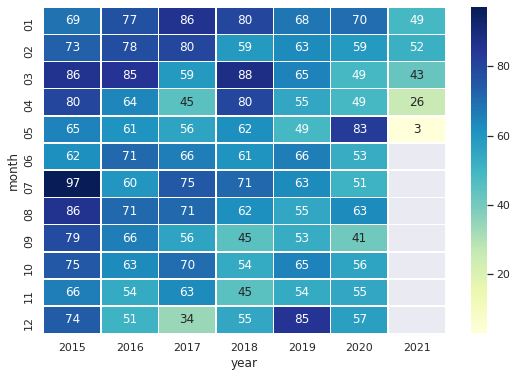

In [227]:
dados = df[['year', 'month']].value_counts().sort_index().to_frame()
dados.reset_index(inplace=True)
dados.columns = ['year', 'month', 'qtd']

sns.set_theme()

flights = dados.pivot("month", "year", "qtd")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

# Análise 8 - Relação entre Problema Mental e Gênero dos Mortos

Grafico utilizado: Donut Chart.

Uma das informaçõe coletadas por esse dataset, é se o Assassinado possuia ou não problema mental, e apesar do número de pessoas que não possuem ser maior, é impressionante a quantidade de pessoas que são assassinadas e pessuem problema mental

In [247]:
fig = go.Figure(data=[go.Pie(labels=['Não Possui Problema Mental', 'Possui Problema Mental'], values=df['signs_of_mental_illness'].value_counts(normalize=True).to_list(), hole=.5)])
fig.show()

In [248]:
fig = go.Figure(data=[go.Pie(labels=['Não Possui Problema Mental', 'Possui Problema Mental'], values=df[df.gender=='F']['signs_of_mental_illness'].value_counts(normalize=True).to_list(), hole=.5)])
fig.show()

In [249]:
fig = go.Figure(data=[go.Pie(labels=['Não Possui Problema Mental', 'Possui Problema Mental'], values=df[df.gender=='M']['signs_of_mental_illness'].value_counts(normalize=True).to_list(), hole=.5)])
fig.show()

# Análise 9 - WordCloud das Armas mais utilizadas

Grafico utilizado: WordCloud.

Vimos acima que o tipo "arma de fogo" é o mais utilizado pelos assassinados, porem essa diferença não parece ser tão grande quando realizamos um wordCloud, onde seguido da "arma de fogo", a faca é o objeto mais utilizado.

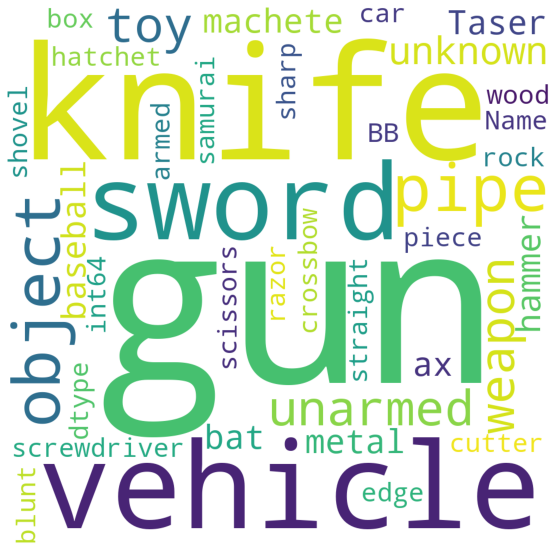

In [250]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')
wc = WordCloud(width = 1000, height = 1000, background_color = 'white').generate(str(df['armed'].value_counts().head(30)))
plt.imshow(wc)
plt.axis('off')
plt.show()

# Análise 10 - Utilização das câmeras de corpo ao Longo dos Anos

Grafico utilizado: Bar Chart with Labels and Filters.

As câmeras de corpo são equipamentos essenciais para um policial, eles reguardam tanto a vítima, quanto o próprio policial, porem podemos ver que a utilização desse equipamento continua muito baixo em comparação com a não utilização.

In [230]:
slider = alt.binding_range(min=2015, max=2021, step=1)
select_year = alt.selection_single(name='year', fields=['year'],
                                   bind=slider, init={'year': 2015})

dados = df
dados['year'] = dados['year'].astype('int64')

bars = alt.Chart(dados).mark_bar().encode(
    x='count():Q',
    y="body_camera:O"
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=2
).encode(
    text='count():Q'
)

(bars + text).properties(height=400).add_selection(select_year).transform_filter(select_year)

alt.LayerChart(...)